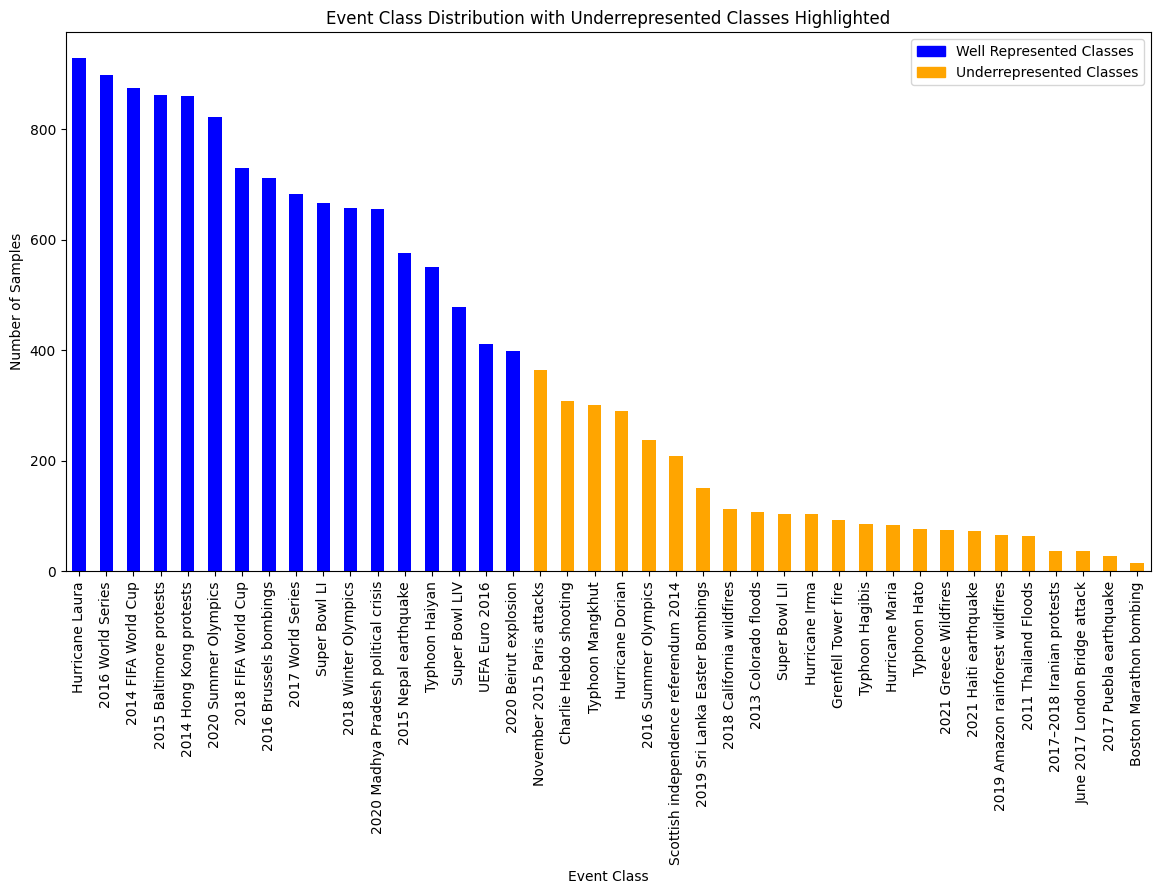

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

class_counts = data['Event_name'].value_counts()
underrepresented_classes = class_counts[class_counts < class_counts.mean()]

plt.figure(figsize=(14, 7))
bar_colors = ['orange' if event in underrepresented_classes.index else 'blue' for event in class_counts.index]
class_counts.plot(kind='bar', color=bar_colors)

blue_patch = mpatches.Patch(color='blue', label='Well Represented Classes')
orange_patch = mpatches.Patch(color='orange', label='Underrepresented Classes')
plt.legend(handles=[blue_patch, orange_patch])

plt.title('Event Class Distribution with Underrepresented Classes Highlighted')
plt.xlabel('Event Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for 

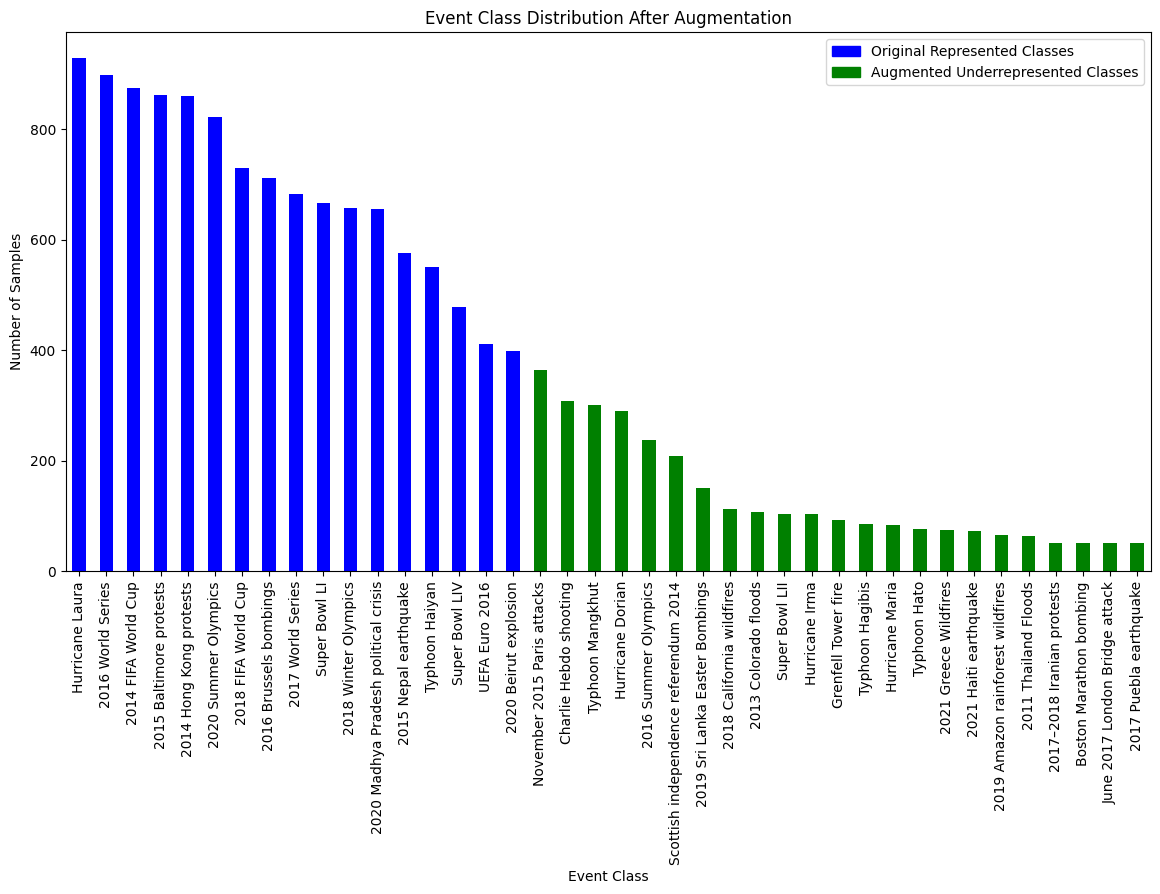

In [ ]:
import torch
from transformers import pipeline
import pandas as pd
import random
import string
import uuid
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

generator = pipeline('text-generation', model='gpt2')

def generate_synthetic_text(prompt, num_samples=5):
    generated_texts = []
    for _ in range(num_samples):
        generated = generator(prompt, max_length=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
        generated_texts.append(generated[0]['generated_text'])
    return generated_texts

def generate_synthetic_image(image_shape=(224, 224, 3)):
    img = np.random.randint(0, 256, image_shape, dtype=np.uint8)
    return Image.fromarray(img)

def augment_data(data, target_col='Event_name', num_samples=50):
    augmented_data = []
    for event in underrepresented_classes.index:
        existing_event_data = data[data[target_col] == event]
        num_existing_samples = len(existing_event_data)

        if num_existing_samples < num_samples:
            sample_texts = generate_synthetic_text(f"Event description for {event}:", num_samples - num_existing_samples)
            for text in sample_texts:
                selected_row = existing_event_data.sample(n=1).iloc[0]

                new_id = str(uuid.uuid4())
                new_image_filename = f"{new_id}.jpg"
                new_image = generate_synthetic_image()
                new_image.save(f"/path/to/save/images/{new_image_filename}")

                new_row = {
                    'Event_id': new_id,
                    'Event_name': event,
                    'Image_link': '',
                    'Text': text,
                    'Time': selected_row['Time'],
                    'Image_filename': new_image_filename,
                    'cleaned_text': text,
                    'text_length': len(text.split()),
                    'Date': selected_row['Date'],
                    'label': selected_row['label']
                }
                augmented_data.append(new_row)

    augmented_df = pd.DataFrame(augmented_data, columns=data.columns)
    data_augmented = pd.concat([data, augmented_df], ignore_index=True)

    return data_augmented

data_augmented = augment_data(data)

new_class_counts = data_augmented['Event_name'].value_counts()
plt.figure(figsize=(14, 7))
bar_colors = ['green' if event in underrepresented_classes.index else 'blue' for event in new_class_counts.index]
new_class_counts.plot(kind='bar', color=bar_colors)

blue_patch = mpatches.Patch(color='blue', label='Original Represented Classes')
green_patch = mpatches.Patch(color='green', label='Augmented Underrepresented Classes')
plt.legend(handles=[blue_patch, green_patch])

plt.title('Event Class Distribution After Augmentation')
plt.xlabel('Event Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()
